# Laplacian spectrum of romance languages

In [1]:
import networkx as nx
import operator
import itertools
from nltk import sent_tokenize
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import numpy as np
import xml.etree.ElementTree as ET
import pickle
from collections import Counter
from numpy import linalg as LA
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster
import operator
from matplotlib.text import TextPath

In [84]:
def extract_bible_text(lang):
    root = ET.fromstring(open(lang + '.xml').read())
    with open(lang + '.txt', 'w', encoding='utf-8') as out:
        for n in root.iter('seg'):
            try:
                out.write(n.text.strip() + '\n')
            except AttributeError:
                pass
    file = open(lang+'.txt', 'r') 
    bible=file.read().split('\n')
    #bible=[item for sublist in bible for item in sublist]
    return bible

## languages

In [85]:
language_names = ['Latin','Spanish','French','Italian','Portuguese','Romanian']
languages = {}
for language in language_names:
    languages[language]=extract_bible_text(language)#' '.join(extract_bible_text(language))

In [86]:
languages['Latin'][:10]

['in principio creavit Deus caelum et terram',
 'terra autem erat inanis et vacua et tenebrae super faciem abyssi et spiritus Dei ferebatur super aquas',
 'dixitque Deus fiat lux et facta est lux',
 'et vidit Deus lucem quod esset bona et divisit lucem ac tenebras',
 'appellavitque lucem diem et tenebras noctem factumque est vespere et mane dies unus',
 'dixit quoque Deus fiat firmamentum in medio aquarum et dividat aquas ab aquis',
 'et fecit Deus firmamentum divisitque aquas quae erant sub firmamento ab his quae erant super firmamentum et factum est ita',
 'vocavitque Deus firmamentum caelum et factum est vespere et mane dies secundus',
 'dixit vero Deus congregentur aquae quae sub caelo sunt in locum unum et appareat arida factumque est ita',
 'et vocavit Deus aridam terram congregationesque aquarum appellavit maria et vidit Deus quod esset bonum']

In [87]:
languages['Spanish'][:10]

['En el principio creó Dios los cielos y la tierra',
 'Y la tierra estaba sin orden y vacía. Había tinieblas sobre la faz del océano, y el Espíritu de Dios se movía sobre la faz de las aguas',
 'Entonces dijo Dios: "Sea la luz", y fue la luz',
 'Dios vio que la luz era buena, y separó Dios la luz de las tinieblas',
 'Dios llamó a la luz Día, y a las tinieblas llamó Noche. Y fue la tarde y fue la mañana del primer día',
 'Entonces dijo Dios: "Haya una bóveda en medio de las aguas, para que separe las aguas de las aguas.',
 'E hizo Dios la bóveda, y separó las aguas que están debajo de la bóveda, de las aguas que están sobre la bóveda. Y fue así',
 'Dios llamó a la bóveda Cielos. Y fue la tarde y fue la mañana del segundo día',
 'Entonces dijo Dios: "Reúnanse las aguas que están debajo del cielo en un solo lugar, de modo que aparezca la parte seca." Y fue así',
 'Llamó Dios a la parte seca Tierra, y a la reunión de las aguas llamó Mares; y vio Dios que esto era bueno']

## tokenization

In [88]:
def clean(language):
    language=[[w.lower() for w in tokenizer.tokenize(sentence)] for sentence in language if len([w.lower() for w in tokenizer.tokenize(sentence)])>0]
    return language

In [89]:
for language in language_names:
    languages[language]=clean(languages[language])

In [90]:
words={}
for language in languages:
    words[language]=[len([item for sublist in languages[language] for item in sublist]),len(set([item for sublist in languages[language] for item in sublist])),Counter([item for sublist in languages[language] for item in sublist])]
    print(language,len(languages[language]),len([item for sublist in languages[language] for item in sublist]),len(set([item for sublist in languages[language] for item in sublist])))

Latin 31211 534301 42089
Spanish 31100 718543 26308
French 31102 782838 20532
Italian 31280 679747 29984
Portuguese 31092 707005 26111
Romanian 31102 720900 20345


In [91]:
most={}
for language in languages:
    most[language]=list(zip(*words[language][2].most_common(15000)))[0]

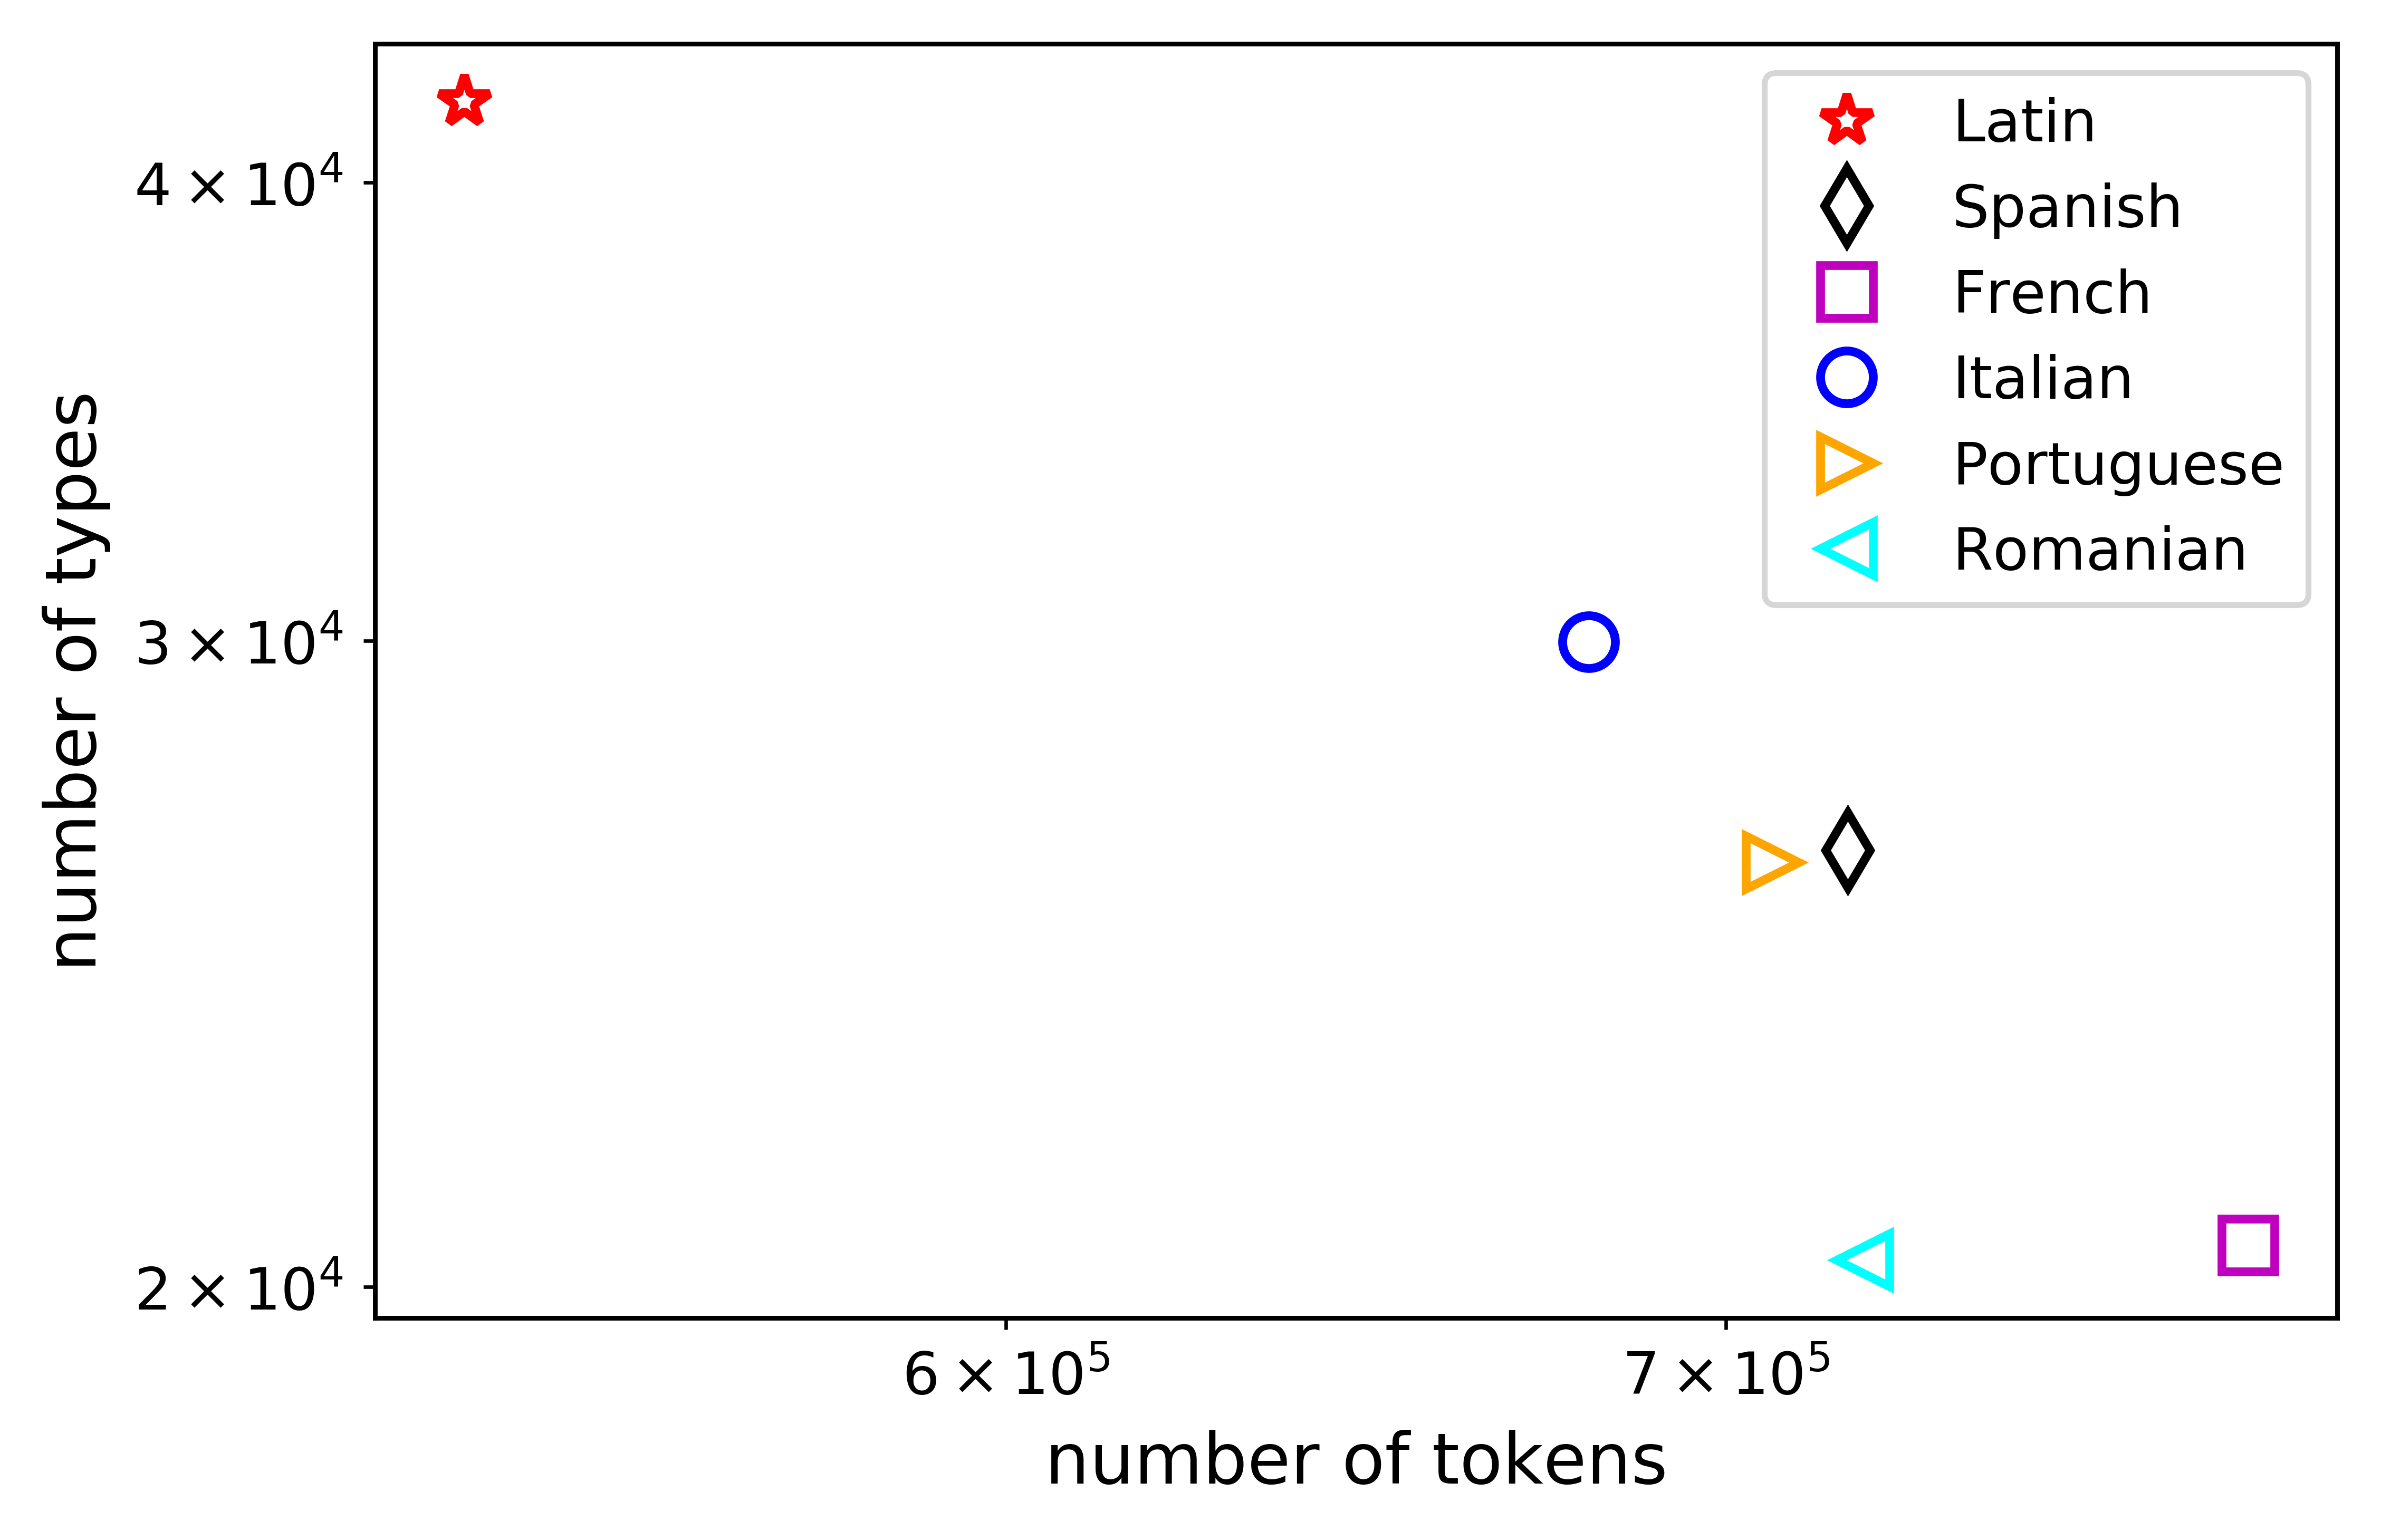

In [11]:
colors={'Latin':['r','*'],'Spanish':['k','d'],'French':['m','s'],'Italian':['b','o'],'Portuguese':['orange','>'],'Romanian':['cyan','<']}
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(dpi=800)

for language in language_names:
    path = TextPath((-20,4), language,linewidth=1)

    # These dots are to display the weakness below, remove for the actual question
    plt.loglog(words[language][0],words[language][1],marker=colors[language][1],color=colors[language][0],markersize=9,linewidth=0,markeredgewidth=1.5,fillstyle='none',clip_on=True,label=language)
    #ax.plot(x[i],y[i],marker=path,markersize=75, color=colors[k_means.labels_[i]],markeredgewidth=0.5,clip_on=True)
    #ax.annotate(language, color='k', xy=(words[language][0]+0.05,words[language][1]+0.05), fontsize=15)

plt.grid(False)
plt.legend(loc='best')
#plt.xlim([-4.25,7.25])
#plt.ylim([-1.75,2.25])
plt.ylabel(r'number of types',fontsize=12)
plt.xlabel(r'number of tokens',fontsize=12)
plt.rcParams.update({'font.size': 10})
plt.savefig('words_languages.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

## graphs

In [92]:
def GoW(text_clean,language):
    W=most[language]
    G=nx.Graph()
    for sentence in text_clean:
        unique_words=list(set(sentence))
        pairs=list(itertools.combinations(unique_words,2)) ## sin repeticion!
        for pair in pairs:
            if pair[0] in W and pair[1] in W:
                if G.has_edge(pair[0],pair[1])==False:
                    G.add_edge(pair[0],pair[1],weight=1)
                else:
                    x=G[pair[0]][pair[1]]['weight']
                    G[pair[0]][pair[1]]['weight']=x+1
        
    return G

In [93]:
graphs={}
for language in language_names:
    print(language)
    G=GoW(languages[language],language)
    graphs[language]=G

Latin
Spanish
French
Italian
Portuguese
Romanian


In [94]:
pickle.dump(graphs,open('bible_graphs.p','wb'))

In [8]:
graphs=pickle.load(open('bible_graphs.p','rb'))

In [10]:
for language in language_names:
    print(language,nx.is_connected(graphs[language]))

Latin True
Spanish True
French False
Italian True
Portuguese True
Romanian False


## laplacian spectrum!

In [11]:
def eigs_laplacian(language):
    G=graphs[language]
    M=nx.normalized_laplacian_matrix(G,weight='weight').todense()
    return LA.eigvals(M)

In [12]:
language_names = ['Latin','Spanish','French','Italian','Portuguese','Romanian']

eigs={}
for language in language_names:
    print(language)
    L=list(np.round_(eigs_laplacian(language),4))
    L.sort()
    eigs[language]=[np.real(x) for x in L]

Latin
Spanish
French
Italian
Portuguese
Romanian


In [13]:
eigs['Romanian'][:10]

[-0.0, -0.0, 0.0, 0.0, 0.3319, 0.3803, 0.3982, 0.4, 0.4214, 0.4319]

In [15]:
pickle.dump(eigs,open('eigs.p','wb'))

In [2]:
eigs=pickle.load(open('eigs.p','rb'))

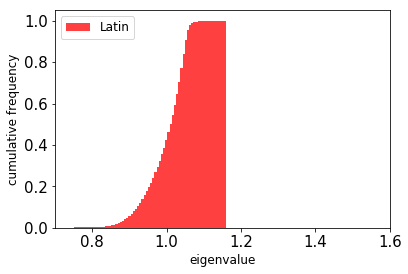

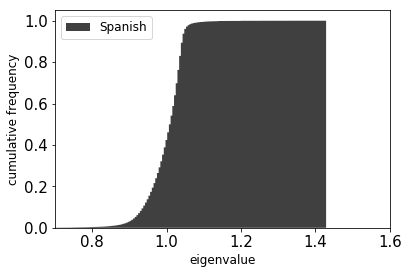

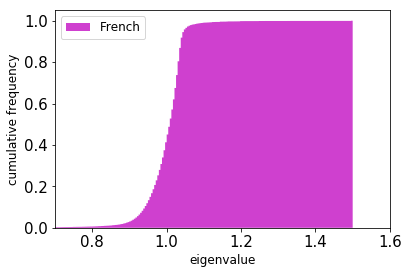

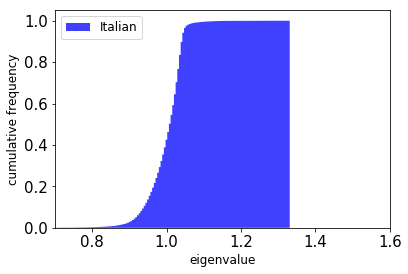

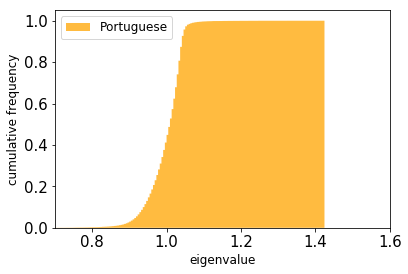

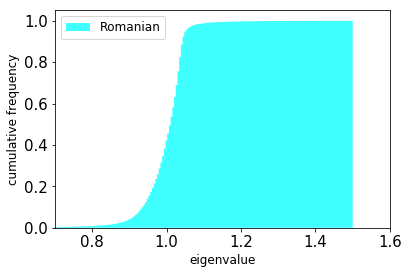

In [9]:
language_names = ['Latin','Spanish','French','Italian','Portuguese','Romanian']

colors={'Latin':['r','*'],'Spanish':['k','d'],'French':['m','s'],'Italian':['b','o'],'Portuguese':['orange','>'],'Romanian':['cyan','<']}

for language in language_names:
    data = np.array(eigs[language])
    plt.xlim([0.7, 1.6])
    plt.hist(data, bins='auto', cumulative=True, histtype='stepfilled', stacked=True,density=True,linewidth=1.25, alpha=0.75, color=colors[language][0],label=language)

    plt.legend(loc='upper left',fontsize=12)
    plt.xlabel('eigenvalue',fontsize=12)
    plt.ylabel('cumulative frequency',fontsize=12)
    plt.rcParams.update({'font.size': 15})
    plt.savefig('hist_'+language+'.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    plt.show()

## laplacian spectra distance
### https://www.sciencedirect.com/science/article/abs/pii/S0024379517303130
### https://www.sciencedirect.com/science/article/pii/S0024379511006021

In [10]:
def distance(language):
    return sum([np.abs(x-y) for x,y in zip(eigs['Latin'],eigs[language])])  

In [11]:
distances_laplacian={language_names[i]:distance(language_names[i])  for i in range(len(language_names))}

In [12]:
sorted(distances_laplacian.items(), key=operator.itemgetter(1),reverse=False)

[('Latin', 0.0),
 ('Spanish', 122.2899000000007),
 ('Portuguese', 129.02750000000083),
 ('Italian', 133.0117000000004),
 ('Romanian', 139.92389999999983),
 ('French', 173.70670000000104)]

## PCA!

In [27]:
X=[]
for language in language_names:
    X+=[eigs[language]]
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit(X).transform(X)

In [28]:
distances={language_names[i]:cosine_similarity(X[0].reshape(1, -1),X[i].reshape(1, -1)) for i in range(len(language_names))}

In [29]:
sorted(distances.items(), key=operator.itemgetter(1),reverse=True)

[('Latin', array([[1.]])),
 ('Romanian', array([[-0.12811825]])),
 ('Portuguese', array([[-0.72364618]])),
 ('Spanish', array([[-0.78388657]])),
 ('Italian', array([[-0.87535489]])),
 ('French', array([[-0.98945252]]))]

In [23]:
X

array([[ 248.68452102,   -5.44682979],
       [ -29.59266178,  -22.40305697],
       [-110.73848594,   18.69772078],
       [ -54.79305847,  -28.71611274],
       [ -45.1049366 ,  -41.17049431],
       [  -8.45537823,   79.03877301]])

In [121]:
x=list(zip(*list(X)))[0]
y=list(zip(*list(X)))[1]

In [122]:
k_means = cluster.KMeans(n_clusters=2, n_init=1)
k_means.fit(X) 
k_means.labels_

array([1, 0, 0, 0, 0, 0], dtype=int32)

In [123]:
center_x=list(zip(*k_means.cluster_centers_))[0]
center_y=list(zip(*k_means.cluster_centers_))[1]

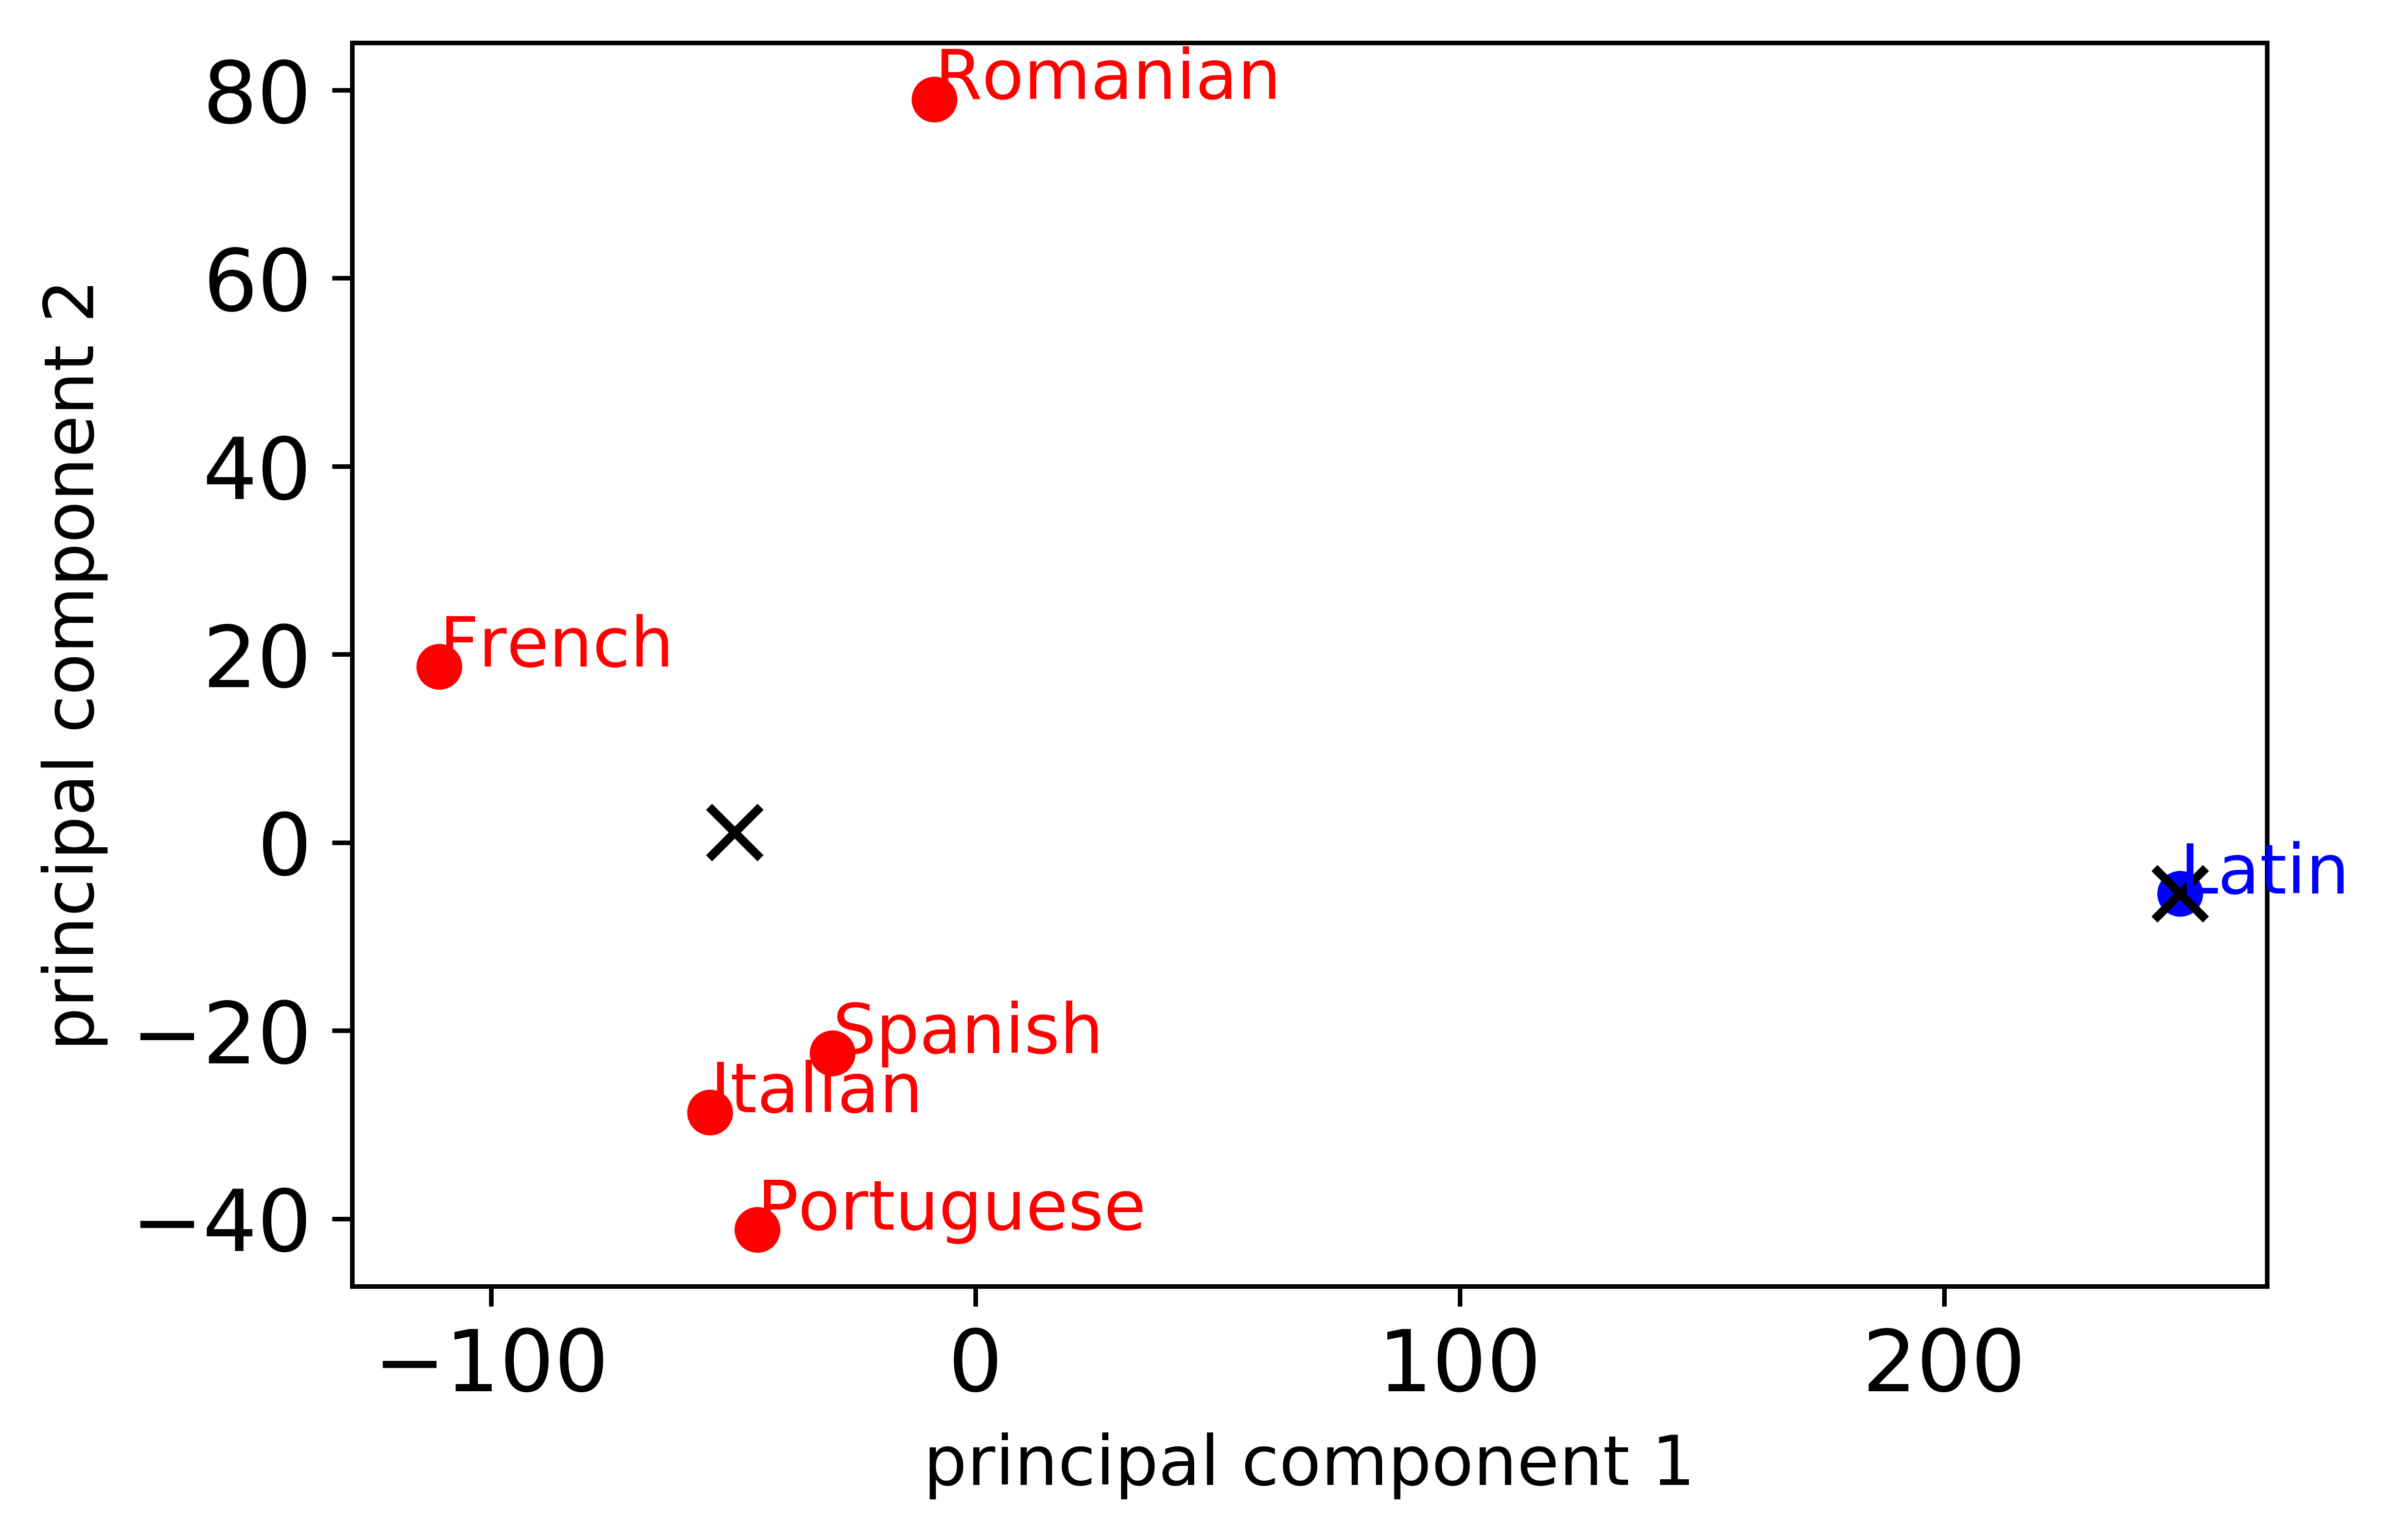

In [124]:
colors=['r','b']
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(dpi=800)

for i in range(len(x)):
    path = TextPath((-20,4), language_names[i],linewidth=1)

    # These dots are to display the weakness below, remove for the actual question
    plt.plot(x[i],y[i],'o',color=colors[k_means.labels_[i]],markersize=7,markeredgewidth=1.,fillstyle='full',clip_on=True)
    #ax.plot(x[i],y[i],marker=path,markersize=75, color=colors[k_means.labels_[i]],markeredgewidth=0.5,clip_on=True)
    ax.annotate(language_names[i], color=colors[k_means.labels_[i]], xy=(x[i]+0.05,y[i]+0.05), fontsize=12)
for i in range(len(colors)):
    ax.plot(center_x[i],center_y[i],'x',color=colors[i],markersize=9,markeredgewidth=1.5,markeredgecolor='k',fillstyle='full',clip_on=True)

plt.grid(False)
#plt.xlim([-4.25,7.25])
#plt.ylim([-1.75,2.25])
plt.ylabel(r'principal component 2',fontsize=12)
plt.xlabel(r'principal component 1',fontsize=12)
plt.rcParams.update({'font.size': 15})
plt.savefig('PCA.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()